In [ ]:
import numpy as np
import bz2
from collections import Counter
import re
import nltk
import torch
import math
import random
from torch import nn
from torch import optim
from torch import Tensor
from torch import LongTensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [ ]:
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logging.getLogger().setLevel(logging.INFO)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_Softargmax = nn.Softmax  # fix wrong name

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !nvidia-smi

In [ ]:
data_dir = '/content/drive/My Drive/RA - Pathak/Attn/data/'

### Load the dataset

In [ ]:
nltk.download('punkt')

ts_file = bz2.BZ2File(data_dir + "test.ft.txt.bz2")
tr_file = bz2.BZ2File(data_dir + "train.ft.txt.bz2")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tr_file = tr_file.readlines()
ts_file = ts_file.readlines()

In [ ]:
num_train = 200000  # We're training on the first 800,000 reviews in the dataset
num_test = 20000  # Using 200,000 reviews from test set
#trn_file = random.sample(tr_file, num_train)
#tst_file = random.sample(tr_file, num_test)

In [ ]:
train_file = [x.decode('utf-8') for x in tr_file[:num_train]]
test_file = [x.decode('utf-8') for x in ts_file[:num_test]]
#train_file = [x.decode('utf-8') for x in trn_file]
#test_file = [x.decode('utf-8') for x in tst_file]

### Preprocessing

In [ ]:
# Extracting labels from sentences
train_labels = [[0,1] if x.split(' ')[0] == '__label__1' else [1,0] for x in train_file]
# train_labels = [[0,1] if x.split(' ')[0] == '__label__1' else [1,0] for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [[0,1] if x.split(' ')[0] == '__label__1' else [1,0] for x in test_file]
# test_labels = [[0,1] if x.split(' ')[0] == '__label__1' else [1,0] for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

# Some simple cleaning of data
for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])

# Modify URLs to <url>
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [ ]:
train_sentences[1]

In [ ]:
a = ["i'm a dota"]
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
        
for i, test_str in enumerate(a):
    for ele in test_str:  
        if ele in punc:  
            if ele == "'":
                a[i] = a[i].replace(ele, "")  
            else:
                a[i] = a[i].replace(ele, " ")  

a

In [ ]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

for i, test_str in enumerate(test_sentences):
    for ele in test_str:  
        if ele in punc:  
            if ele == "'":
                test_sentences[i] = test_sentences[i].replace(ele, "")  
            else:
                test_sentences[i] = test_sentences[i].replace(ele, " ")  

for i, train_str in enumerate(train_sentences):
    for ele in train_str:  
        if ele in punc:  
            if ele == "'":
                train_sentences[i] = train_sentences[i].replace(ele, "")  
            else:
                train_sentences[i] = train_sentences[i].replace(ele, " ")  

In [ ]:
train_sentences[1]

In [ ]:
words = Counter()  # Dictionary that will map a word to the number of times it appeared in all the training sentences
for i, sentence in enumerate(train_sentences):
    # The sentences will be stored as a list of words/tokens
    train_sentences[i] = []
    for word in nltk.word_tokenize(sentence):  # Tokenizing the words
        words.update([word.lower()])  # Converting all the words to lowercase
        train_sentences[i].append(word)
    if i%20000 == 0:
        print(str((i*100)/num_train) + "% done")
print("100% done")

In [ ]:
# Removing the words that only appear once
words = {k:v for k,v in words.items() if v>1}
# Sorting the words according to the number of appearances, with the most common word being first
words = sorted(words, key=words.get, reverse=True)
# Adding padding and unknown to our vocabulary so that they will be assigned an inde0x
words = ['_PAD','_UNK'] + words
# Dictionaries to store the word to index mappings and vice versa
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

In [ ]:
for i, sentence in enumerate(train_sentences):
    # Looking up the mapping dictionary and assigning the index to the respective words
    train_sentences[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

for i, sentence in enumerate(test_sentences):
    # For test sentences, we have to tokenize the sentences as well
    test_sentences[i] = [word2idx[word.lower()] if word.lower() in word2idx else 0 for word in nltk.word_tokenize(sentence)]

In [ ]:
# Defining a function that either shortens sentences or pads sentences with 0 to a fixed length
def pad_input(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

seq_len = 200  # The length that the sentences will be padded/shortened to

train_sentences = pad_input(train_sentences, seq_len)
test_sentences = pad_input(test_sentences, seq_len)

# Converting our labels into numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
train_sentences[145]

In [ ]:
len(test_sentences)

In [ ]:
split_frac = 0.5 # 30% validation, 70% test
split_id = int(split_frac * len(test_sentences))
val_sentences, test_sentences = test_sentences[:split_id], test_sentences[split_id:]
val_labels, test_labels = test_labels[:split_id], test_labels[split_id:]

In [ ]:
for i in test_sentences[5]:
    s = idx2word[i]
    if s != '_PAD':
        print(s, end=" ")

In [ ]:

print(len(test_sentences))
print(len(val_sentences))

### Data Loaders

In [ ]:
train_data = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_sentences), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

# batch_size = 100
batch_size = 200
#batch_size = 100


"""
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
"""

train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [ ]:
len(test_loader)
# for d,l in test_loader:
    # print(l)

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

In [ ]:
len(word2idx) + 1

### Multihead Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, p, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesnt saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length)
        
        A = nn_Softargmax(dim=-1)(scores)   # (bs, n_heads, q_length, k_length)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size()

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
        
        # Final linear layer  
        H = self.W_h(H_cat)          # (bs, q_length, dim)
        # print('MHA attn weight shape:', A.shape)
        # print('MHA output shape:', H.shape)
        
        return H, A

In [ ]:
class CNN(nn.Module):
    def __init__(self, d_model, hidden_dim, p):
        super().__init__()
        self.k1convL1 = nn.Linear(d_model,    hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation(x)
        x = self.k1convL2(x)
        return x

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, p=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads, p)
        self.cnn = CNN(d_model, conv_hidden_dim, p)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # Multi-head attention 
        attn_output, attn_weights = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        cnn_output = self.cnn(out1)  # (batch_size, input_seq_len, d_model)
        
        #Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + cnn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_weights

In [ ]:
def create_sinusoidal_embeddings(nb_p, dim, E):
    theta = np.array([
        [p / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
        for p in range(nb_p)
    ])
    E[:, 0::2] = torch.FloatTensor(np.sin(theta[:, 0::2]))
    E[:, 1::2] = torch.FloatTensor(np.cos(theta[:, 1::2]))
    E.detach_()
    E.requires_grad = False
    E = E.to(device)

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings, p):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.position_embeddings = nn.Embedding(max_position_embeddings, d_model)
        create_sinusoidal_embeddings(
            nb_p=max_position_embeddings,
            dim=d_model,
            E=self.position_embeddings.weight
        )

        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device) # (max_seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)                      # (bs, max_seq_length)
        
        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        
        # Get position embeddings for each position id 
        position_embeddings = self.position_embeddings(position_ids)        # (bs, max_seq_length, dim)
        
        # Add them both 
        embeddings = word_embeddings + position_embeddings  # (bs, max_seq_length, dim)
        
        # Layer norm 
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding, p=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Embeddings(d_model, input_vocab_size,maximum_position_encoding, p)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim, p))
        
    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x, attn_weights = self.enc_layers[i](x)

        return x, attn_weights  # (batch_size, input_seq_len, d_model)

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()
        
        # self.encoder = Encoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
        #                  maximum_position_encoding=10000)
        self.encoder = Encoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
                         maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, 64)
        self.dense11 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.3)
        self.tanh = nn.Tanh()
        self.softmax_fc = nn.Softmax(dim=1)
        self.dense2 = nn.Linear(200, num_answers)

    def forward(self, x):
        x, attn_weights = self.encoder(x)
        # print('out1',x.shape)
        # [100,200,32]
        # print('attn1',attn_weights.shape)
        
        #x, _ = torch.max(x, dim=1)
        out = self.dense(x)
        out = self.tanh(out)
        out = self.dense11(out)
        out = self.dropout(out)
        out = self.tanh(out)
        # print('out dense1',out.shape)
        # [100,200,1]
        # print('attn dense1',attn_weights.shape)
        out = out.squeeze()
        # [100,200,1]
        out = self.dense2(out)
        out = self.softmax_fc(out)
        # [100,2]
        # print('out final ',out.shape)
        # print('attn final ',attn_weights.shape)
        return out, attn_weights

In [ ]:
i = torch.Tensor(100,200,32)
dense = nn.Linear(32, 1)
dense2 = nn.Linear(200, 2)
# dense3 = nn.Linear(32, 2)
out = dense(i)
# out = dense2(i)
out = out.squeeze()
out = dense2(out)
# out = softmax_fc(out)
out.shape

### Training

In [ ]:
vocab_size = len(word2idx) + 1
batch_size = 200
output_size = 2
# embedding_dim = 32
embedding_dim = 100
conv_dim = 128
n_layers = 1
drop_prob=0.3

model = TransformerClassifier(num_layers=n_layers, d_model=embedding_dim, num_heads=4,conv_hidden_dim=conv_dim, input_vocab_size=vocab_size, num_answers=output_size)
model.to(device)
# model = Model(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob)
# model = model.to(device)
model

In [ ]:
!nvidia-smi
criterion = nn.BCELoss()

In [ ]:
# [ lr = 0.001,bs=200,d_model=32,conv_dim=32]
model.train()
epochs = 20
sequence_length = seq_len
counter = 0
clip = 5
print_every = 100
valid_loss_min = np.Inf
all_weights = []
all_train_loss = []
all_val_loss = []
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.005)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)
val_dl = val_loader


for epoch in range(epochs):
    #state_h, state_c = model.init_state(sequence_length)
    model.train()
    # h = model.init_state(batch_size)

    train_losses = []
    validation_losses = []

    for inputs, labels in train_loader:
        counter += 1
        # h = tuple([e.data for e in h])
        # h = [x.to(device) for x in h]
        inputs, labels = inputs.to(device), labels.to(device)

        model.zero_grad()
        output, _ = model(inputs)
        loss = criterion(output.squeeze(), labels.float())
        # loss = f.cross_entropy(output, lables)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        
    model.eval()
    # val_h = model.init_state(batch_size)
    for inp, lab in val_loader:
        # val_h = tuple([each.data for each in val_h])
        # val_h = [x.to(device) for x in val_h]
        inp, lab = inp.to(device), lab.to(device)

        out, _  = model(inp)
        val_loss = criterion(out.squeeze(), lab.float())
        #val_loss = f.cross_entropy(out, lab)
        validation_losses.append(val_loss.item())

        
    all_train_loss.append(np.mean(train_losses))
    all_val_loss.append(np.mean(validation_losses))
    
    logging.info("Epoch {}: {:.6f} loss, {:.6f} val loss".format(epoch+1, np.mean(train_losses), np.mean(validation_losses)))

16-Feb-21 01:42:36 - Epoch 1: 0.570568 loss, 0.560374 val loss
16-Feb-21 01:42:57 - Epoch 2: 0.417894 loss, 0.436365 val loss
16-Feb-21 01:43:18 - Epoch 3: 0.368745 loss, 0.371133 val loss
16-Feb-21 01:43:39 - Epoch 4: 0.329717 loss, 0.324958 val loss
16-Feb-21 01:43:59 - Epoch 5: 0.303359 loss, 0.316094 val loss
16-Feb-21 01:44:21 - Epoch 6: 0.281272 loss, 0.300605 val loss
16-Feb-21 01:44:42 - Epoch 7: 0.263111 loss, 0.285475 val loss
16-Feb-21 01:45:03 - Epoch 8: 0.249320 loss, 0.267450 val loss
16-Feb-21 01:45:24 - Epoch 9: 0.238466 loss, 0.244170 val loss
16-Feb-21 01:45:45 - Epoch 10: 0.229986 loss, 0.257570 val loss
16-Feb-21 01:46:06 - Epoch 11: 0.223359 loss, 0.240452 val loss
16-Feb-21 01:46:27 - Epoch 12: 0.217802 loss, 0.236254 val loss
16-Feb-21 01:46:48 - Epoch 13: 0.213332 loss, 0.243058 val loss
16-Feb-21 01:47:09 - Epoch 14: 0.208974 loss, 0.234662 val loss
16-Feb-21 01:47:30 - Epoch 15: 0.205820 loss, 0.228118 val loss
16-Feb-21 01:47:51 - Epoch 16: 0.202166 loss, 0.2

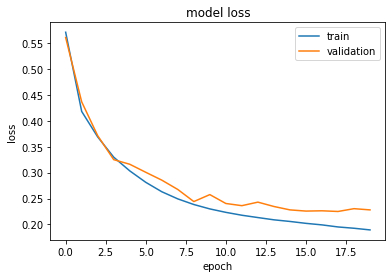

In [ ]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
model_dir = '/content/drive/My Drive/RA - Pathak/Attn/models/'
# torch.save(model, model_dir + "imdb-transformer-200k-latest.pickle")
model = torch.load(model_dir + "imdb-transformer-200k-latest.pickle")

### Testing

In [ ]:
test_losses = []
num_correct = 0
a_weights = []
pred_label = []
true_label = []
prediction = []
test_sen = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output, a_out = model(inputs)

        for out in output:
            o = out.cpu().numpy()
            prediction.append(o)
            #o = out.round().cpu().numpy()
            # if o[0] == 0 :   #this mean _label1_ bad
            #     pred_label.append(0)
            # else:            #this mean _label2_ good
            #     pred_label.append(1)


        for label in labels:
            l = label.cpu().numpy()
            if l[0] == 0 :
                true_label.append(1) # bad review
            else:
                true_label.append(0)

        for inp in inputs:
            test_sen.append(inp.cpu().numpy())
            
        # for each_a_out in a_out:
        #     a_weights.append(each_a_out)
        for each_a_out in a_out:
            m = each_a_out.squeeze()
            m = torch.mean(m,0)
            m = torch.mean(m,0)
            a_weights.append(m.cpu().numpy())
            
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())


print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
#print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.225


In [ ]:
print(len(a_weights))
print(a_weights[0].shape)

10000
(200,)


In [ ]:
print(len(a_weights[0]))

200


### Evaluation

In [ ]:
prediction1 = np.argmax(prediction, axis=1)  ## Prediction for bad reviews in terms of 0 and 1 for all test data
prediction_for_1=[] ## Prediction for bad reviews only
for each_prediction in prediction:
    prediction_for_1.append(each_prediction[1])

c = confusion_matrix(true_label,prediction1)

[Text(0, 0.5, 'good'), Text(0, 1.5, 'bad')]

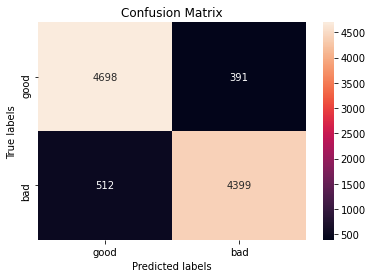

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(c, annot=True, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
# ax.xaxis.set_ticklabels(['good', 'bad']) 
# ax.yaxis.set_ticklabels(['good', 'bad'])
ax.xaxis.set_ticklabels(['good', 'bad']) 
ax.yaxis.set_ticklabels(['good', 'bad'])

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from inspect import signature

truelabel = true_label
predictedlabel = np.array(prediction1)

precision, recall, _ = precision_recall_curve(truelabel,np.array(prediction_for_1))
au = auc(recall, precision)
print("Area under graph "+str(au))
print("-------------------------------------------------")
rec_score = recall_score(truelabel,predictedlabel,pos_label=1,average='binary')
precise_score = precision_score(truelabel,predictedlabel,pos_label=1,average='binary')
f1 = f1_score(truelabel,predictedlabel,pos_label=1, average='binary')
print("Precision for bad reviews "+str(precise_score))
print("Recall for bad reviews "+str(rec_score))
print("F1-score for bad reviews  " + str(f1))
print("-------------------------------------------------")
rec_score = recall_score(truelabel,predictedlabel,pos_label=0,average='binary')
precise_score = precision_score(truelabel,predictedlabel,pos_label=0,average='binary')
f1 = f1_score(truelabel,predictedlabel,pos_label=0, average='binary')
print("Precision for good reviews "+str(precise_score))
print("Recall for good reviews "+str(rec_score))
print("F1-score for good reviews  " + str(f1))

Area under graph 0.9690368921621564
-------------------------------------------------
Precision for bad reviews 0.9183716075156576
Recall for bad reviews 0.8957442476074119
F1-score for bad reviews  0.9069168126997218
-------------------------------------------------
Precision for good reviews 0.9017274472168906
Recall for good reviews 0.9231676164275889
F1-score for good reviews  0.9123215846198659


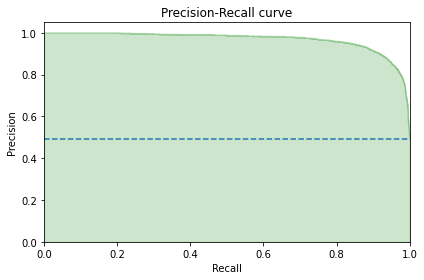

In [ ]:
positive_cases = sum(truelabel)/len(truelabel)
plt.plot([0, 1], [positive_cases, positive_cases], linestyle='--')

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters
                else {})
plt.step(recall, precision, color='g', alpha=0.2,
            where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.tight_layout()

### Test Example 

In [ ]:
sen_index = 103
#[40,1000, 57, 299, 300, 302, 308]

In [ ]:
# print(a_weights[sen_index].shape)
# x = a_weights[sen_index].squeeze()
# ### For multi-heads
# m = torch.mean(x,0)
# print(m.shape)
# m = torch.mean(m,0)
# print(m[0].shape)

In [ ]:
sen_index3 = 388
sen_index1 = 345
sen_index2 = 483

ts1 = test_sen[sen_index1]
ts2 = test_sen[sen_index2]
ts3 = test_sen[sen_index3]
for i in ts1:
    s = idx2word[i]
    if s != '_PAD':
        print(s, end=" "),

print("\n")

for i in ts2:
    s = idx2word[i]
    if s != '_PAD':
        print(s, end=" "),
        
print("\n")

for i in ts3:
    s = idx2word[i]
    if s != '_PAD':
        print(s, end=" "),

darn compelling argument some other guy named shakespeare wrote all that stuff but not the shakespeare we know or actually dont 

confused i just opened it today and i am disappointed the outside of the box states it is a floor cover and not the trunk tray as written on the shipping label i really dont know if they shipped the wrong item it is supposed to be 00 by 0ft it is not so i am not sure if i got the correct item and i dont want to have to pay to ship it back it is pretty bent i am hoping it straightens out a friend of mine just bought a new fe and admired my cargo tray so i bought her one it is not as thick as the one i have 

fantastic i love this book absolutely a keeper the length of time it for the book to get to me was very short i am very satisfied 

In [ ]:
dict1 = {}
dict2 = {}
dict3 = {}

for i in range(0,200):
    s = idx2word[ts1[i]]
    dict1[s] = a_weights[sen_index1][i]
    # dict[s] = a_weights[0][0][0][i].cpu().detach().numpy()


cols = ['values']
df1 = pd.DataFrame.from_dict(dict1, orient='index', columns = cols)
df1 = df1.sort_values(by='values', ascending=False)
print(df1.head(20))

for i in range(0,200):
    s = idx2word[ts2[i]]
    if s != '_PAD' and s!= '00':
        dict2[s] = a_weights[sen_index2][i]
    # dict[s] = a_weights[0][0][0][i].cpu().detach().numpy()
df2 = pd.DataFrame.from_dict(dict2, orient='index', columns = cols)
df2 = df2.sort_values(by='values', ascending=False)
print(df2.head(20))

for i in range(0,200):
    s = idx2word[ts3[i]]
    if s != '_PAD' and s!= '00':
        dict3[s] = a_weights[sen_index3][i]
    # dict[s] = a_weights[0][0][0][i].cpu().detach().numpy()

df3 = pd.DataFrame.from_dict(dict3, orient='index', columns = cols)
df3 = df3.sort_values(by='values', ascending=False)
cols = ['values']
print(df3.head(20))


               values
compelling   0.029687
dont         0.028597
actually     0.026817
argument     0.025644
shakespeare  0.025401
know         0.024720
but          0.024132
darn         0.021567
wrote        0.019417
or           0.017961
we           0.015371
named        0.014755
guy          0.014482
stuff        0.013553
not          0.012889
some         0.012393
other        0.012239
all          0.010660
that         0.009278
the          0.007847
                values
confused      0.038099
disappointed  0.021716
opened        0.013702
thick         0.013656
today         0.011984
hoping        0.011407
tray          0.011329
one           0.010502
as            0.010423
have          0.010187
cover         0.010051
admired       0.009816
cargo         0.009593
fe            0.009506
bought        0.009279
states        0.009121
outside       0.009066
sure          0.008758
trunk         0.008524
not           0.008492
              values
satisfied   0.044104
fantastic   0

In [ ]:
df1.head(10)

,values
compelling,0.029687
dont,0.028597
actually,0.026817
argument,0.025644
shakespeare,0.025401
know,0.024720
but,0.024132
darn,0.021567
wrote,0.019417
or,0.017961


In [ ]:
df2.head(10)

,values
confused,0.038099
disappointed,0.021716
opened,0.013702
thick,0.013656
today,0.011984
hoping,0.011407
tray,0.011329
one,0.010502
as,0.010423
have,0.010187


In [ ]:
df3.head(10)

,values
satisfied,0.044104
fantastic,0.042724
love,0.030402
short,0.026437
keeper,0.023465
very,0.020331
am,0.019474
absolutely,0.017970
was,0.017740
length,0.016012
